In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Bring all the data into a single dataframe.
Sample of the data is located in the Google Drive folder (link below). One zip file for each month for the year of 2017
https://drive.google.com/drive/folders/1lZJhPM24i9PQRW_nOTQj5sQy3FTiwhbY?usp=sharing


In [2]:
path = './Data/AirlineData/2017/'
all_files = glob.glob(os.path.join(path, "*.zip"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, compression='zip', parse_dates=['FL_DATE']) for f in all_files)
concatenated_df = pd.concat(df_from_each_file)

In [3]:
concatenated_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5674621 entries, 0 to 410516
Data columns (total 33 columns):
YEAR                   int64
MONTH                  int64
DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
FL_DATE                datetime64[ns]
OP_CARRIER             object
ORIGIN                 object
ORIGIN_CITY_NAME       object
ORIGIN_STATE_ABR       object
DEST                   object
DEST_CITY_NAME         object
DEST_STATE_ABR         object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DELAY_NEW          float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
N

In [4]:
#define a function to find memory usage 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

# Get all the int-type data

In [5]:
df_int = concatenated_df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

303.06 MB
92.00 MB


# Get all the float-type data

In [6]:
df_float = concatenated_df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

865.88 MB
454.59 MB


# Create an optimized copy of df

In [7]:
optimized_df = concatenated_df.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(concatenated_df))
print(mem_usage(optimized_df))

3533.38 MB
2911.03 MB


# Get all the object-type data

In [8]:
df_obj = concatenated_df.select_dtypes(include=['object']).copy()

In [9]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

2407.74 MB
102.95 MB


In [10]:
optimized_df[converted_obj.columns] = converted_obj
mem_usage(optimized_df)

'606.25 MB'

In [11]:
optimized_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5674621 entries, 0 to 410516
Data columns (total 33 columns):
YEAR                   uint16
MONTH                  uint8
DAY_OF_MONTH           uint8
DAY_OF_WEEK            uint8
FL_DATE                datetime64[ns]
OP_CARRIER             category
ORIGIN                 category
ORIGIN_CITY_NAME       category
ORIGIN_STATE_ABR       category
DEST                   category
DEST_CITY_NAME         category
DEST_STATE_ABR         category
CRS_DEP_TIME           uint16
DEP_TIME               float32
DEP_DELAY              float32
DEP_DELAY_NEW          float32
TAXI_OUT               float32
WHEELS_OFF             float32
WHEELS_ON              float32
TAXI_IN                float32
CRS_ARR_TIME           uint16
ARR_TIME               float32
ARR_DELAY              float32
ARR_DELAY_NEW          float32
ACTUAL_ELAPSED_TIME    float32
AIR_TIME               float32
DISTANCE               float32
CARRIER_DELAY          float32
WEATHER_DELAY  

In [12]:
optimized_df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 32'],
      dtype='object')

In [13]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x, y

In [14]:
x_air_time, y_air_time=ecdf(optimized_df.ARR_DELAY)

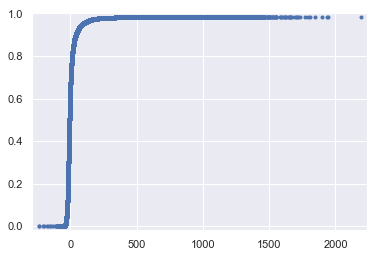

In [15]:
_ = plt.plot(x_air_time, y_air_time, marker='.', linestyle='none')
plt.margins(0.02)
plt.show()